# Create Padding Change Color

**Note:**
- The fundamental idea here is data augmentation. We can change position in the grid, as well as color. We can also try other techniques
- But instead of moving the target pattern around, we can 'move' it just by adjusting the padding and number of rows and columns, then use Cartesian multiplication
- We are currently swapping two colors (the first two in any list). We can probably use cartesian lists in order to do a smarter swap
- Setting pad=0 seems to do the same thing as just converting the original. Not sure about this. But it does append to the name, e.g. tra_0_007bbfb7_pd__0r0c.png
- Currently writing out pairs, but to the colors folder of full_task. This should be fixed(?). The only reason to write out the entire task is to see it colorized. If needed, then see https://www.kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines


In [1]:
import numpy as np
import pandas as pd
import torch
import os
import json
from pathlib import Path
import re
import itertools
from itertools import product
from torchtext import data
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import colors

# thank you to "visualizing all task pairs with gridlines" and "starter notebook"!


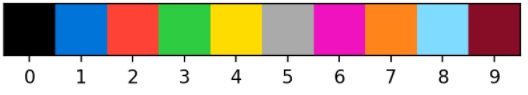

In [2]:
# tensorToColor = [[4, 4, 4],
#         [2, 3, 2],
#         [2, 3, 3]]
# uniqueValues = torch.unique(torch.tensor(tensorToColor, dtype=torch.long))
# uniqueValuesToArray = uniqueValues.numpy()
# boogie = np.random.choice(uniqueValuesArray,2)
# # print(type(uniqueValues.numpy()))
# boogie
# colorMyTensor(tensorToColor)

In [3]:
# list comprehension with ternary operator
a=[1,2,3,1,3,2,1,1]
[4 if x==1 else x for x in a]

[4, 2, 3, 4, 3, 2, 4, 4]

In [4]:
# for dirname, _, filenames in os.walk('/storage/data'):
#     print(dirname)

In [5]:
# Define Paths
# 
# data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
# here it's in /storage/data

data_path = Path('/storage/data/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
augment_path = data_path / 'augment'
fulltask_path = augment_path / 'fulltask'
subtask_path = augment_path / 'subtask'
task_color_path = fulltask_path / 'color'

substring = '.json'
baseName = ""

# define the list of tasks we're going to be iterating through
training_tasks = sorted(os.listdir(training_path))
print(len(training_tasks))
# for i, json_path in enumerate(training_tasks[0:10]):
    
#     task_file = str(training_path / json_path)
# #     print(task_file)
#     with open(task_file, 'r') as f:
#         task = json.load(f)
# print a list of task_files, e.g. 000 /storage/data/training/007bbfb7.json
#    print(f"{i:03d}", task_file)

FileNotFoundError: [Errno 2] No such file or directory: '/storage/data/training'

# ***Naming Things With Meaning***


In [ ]:
 # ***Function to rename shapeString, e.g. "10x10"***
def makeShapeStringXByY (inputOrOutput):
    x = str(inputOrOutput[0])
    y = str(inputOrOutput[1])
    xToInsert = "x"
    shapeString = x + xToInsert + y
    return shapeString

In [ ]:
def showSizeIncrease(originalInputOrOutputSize, paddedInputOrOutputSize):
    #  trainingSizeIncrease = showSizeIncrease(originalTrainingInputSize, paddedTrainingInputSize)
    originalRows = originalInputOrOutputSize[0]
    originalColumns = originalInputOrOutputSize[1]
    paddedRows = paddedInputOrOutputSize[0]
    paddedColumns = paddedInputOrOutputSize[1]
    rowDifference = (paddedRows - originalRows)
    # cast to int so we don't have decimal points
    rowDifference = int(rowDifference)
    columnDifference = int(paddedColumns - originalColumns)
    columnDifference = int(columnDifference)
    strRowDifference = str(rowDifference)
    strColumnDifference = str(columnDifference)
    sizeIncreaseText = "_" + strRowDifference + "r" + strColumnDifference + "c"
    return sizeIncreaseText

**Function to add "pd" to any Padding filename. For Shifts, it will add indicators for down, up, left, right**

In [ ]:
def makePaddingString(yShift, xShift):
    xChangeString = ""
    yChangeString = ""
    if(xShift == 0 and yShift == 0):
        xChangeString = "pd_"
        yChangeString = ""
    
    if(yShift > 0):
        yChangeString = "D" + str(yShift)
    elif(yShift < 0):
        yChangeString = "U" + str(abs(yShift))
# say yShift is 2.  We're going D2. That means if we started with no pad, we now have a pad of 2 above.
# That in turn means we have to have added at least 2.

    if(xShift > 0):
        xChangeString = "R" + str(xShift)
    elif(xShift < 0):
        xChangeString = "L" + str(abs(xShift))
    
    return yChangeString, xChangeString

In [ ]:
def plot_task(task, baseName="newNumber"):
    """
    Plots however many train and test pairs there are of a specified task,
    using same color scheme as the ARC app
    Here in Create Padding Change Color, the path is changed to task_color_path
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    # 0 black, 1 blue, 2 red, 3 green, 4 yellow, 5 grey, 6 pink, 7 orange, 8 light blue, 9 brown
    # loop through training pairs
    training_pair_counter = 0
    for training_pair_counter in range(n_train_pairs):
        # variable assignment: assigns 1 to fig and 2 to ax
        fig, ax = plt.subplots(1, 2)
#             print(" training_pair_counter in plot_task = "+ str(training_pair_counter))
        # temporarily:
#             print(type(task['train'][training_pair_counter]['input']))
#             print("task['train'][training_pair_counter]['input']: ", task['train'][training_pair_counter]['input'])
        ax[0].imshow(task['train'][training_pair_counter]['input'], cmap=cmap, norm=norm)
        width = np.shape(task['train'][training_pair_counter]['input'])[1]
        height = np.shape(task['train'][training_pair_counter]['input'])[0]
        ax[0].set_xticks(np.arange(-.5,width))
        ax[0].set_yticks(np.arange(-.5,height))
        ax[0].set_xticklabels([])
        ax[0].set_yticklabels([])
        ax[0].tick_params(length=0)
        ax[0].grid(True)
        ax[0].set_title('trIn_' + str(training_pair_counter) + '_' + baseName)
        # the output for the corresponding training task
        ax[1].imshow(task['train'][training_pair_counter]['output'], cmap=cmap, norm=norm)
        width = np.shape(task['train'][training_pair_counter]['output'])[1]
        height = np.shape(task['train'][training_pair_counter]['output'])[0]
        ax[1].set_xticks(np.arange(-.5,width))
        ax[1].set_yticks(np.arange(-.5,height))
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].tick_params(length=0)
        ax[1].grid(True)
        train_pair_name = 'tra_' + str(training_pair_counter) + '_' + baseName
        ax[1].set_title('trOut_' + str(training_pair_counter) + '_' + baseName)
        plt.tight_layout()
        train_pair_file_name_with_path = os.path.join(str(task_color_path), train_pair_name)
        print("train_pair_file_name_with_path in plot_task: ", train_pair_file_name_with_path)
        plt.savefig(train_pair_file_name_with_path)
        plt.show()
        plt.close()
            
    # the input and output for the test pair n_test_pairs
    for test_pair_counter in range(n_test_pairs):
        figure, axis = plt.subplots(1, 2)
        axis[0].imshow(task['test'][test_pair_counter]['input'], cmap=cmap, norm=norm)
        width = np.shape(task['test'][test_pair_counter]['input'])[1]
        height = np.shape(task['test'][test_pair_counter]['input'])[0]
        axis[0].set_xticks(np.arange(-.5,width))
        axis[0].set_yticks(np.arange(-.5,height))
        axis[0].set_xticklabels([])
        axis[0].set_yticklabels([])
        axis[0].tick_params(length=0)
        axis[0].grid(True)
        axis[0].set_title('tstIn_' + str(test_pair_counter) + '_' + baseName)
        # test output
        axis[1].imshow(task['test'][test_pair_counter]['output'], cmap=cmap, norm=norm)
        width = np.shape(task['test'][test_pair_counter]['output'])[1]
        height = np.shape(task['test'][test_pair_counter]['output'])[0]
        axis[1].set_xticks(np.arange(-.5,width))
        axis[1].set_yticks(np.arange(-.5,height))
        axis[1].set_xticklabels([])
        axis[1].set_yticklabels([])
        axis[1].tick_params(length=0)
        axis[1].grid(True)
        test_pair_name = 'tst_' + str(test_pair_counter) + '_' + baseName
        axis[1].set_title('tstOut_' + str(test_pair_counter) + '_' + baseName)
        plt.tight_layout()
        test_pair_file_name_with_path = os.path.join(str(task_color_path), test_pair_name)
        plt.savefig(test_pair_file_name_with_path, pad_inches=2)
        plt.show()
        plt.close()



In [ ]:
def plot_subtask(task, baseName="1234"):

    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    # 0 black, 1 blue, 2 red, 3 green, 4 yellow, 5 grey, 6 pink, 7 orange, 8 light blue, 9 brown
    # variable assignment: assigns 1 to fig and 2 to ax
    fig, ax = plt.subplots(1, 2)
    ax.imshow(task, cmap=cmap, norm=norm)
    width = np.shape(task)[1]
    height = np.shape(task)[0]
    ax.set_xticks(np.arange(-.5,width))
    ax.set_yticks(np.arange(-.5,height))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
#         fig.axes.get_xaxis().set_visible(False)
#         fig.axes.get_yaxis().set_visible(False)
    ax.tick_params(length=0)
    ax.grid(True)
    plt.tight_layout()

    file_name_with_path = os.path.join(str(augment_path), baseName)
#     print("file_name_with_path in write_subtask_file: ", file_name_with_path)
    plt.savefig(file_name_with_path)
    plt.show()
    plt.close()

In [ ]:
x = torch.randn(3, 2)
y = torch.ones(3, 2)
print("x is ", x)
print("y is ", y)
calc = torch.where(x > 0, x, y)
print(calc)


In [ ]:


def colorMyTensor(inputTensor, valuesToSwap):
    # here's what we're going to do: if the colors in the input's values appear in the output, then make the
    # same change in the output. Otherwise leave them alone. Because if they don't, then color is irrelevant --
    # it's got something to do with the pattern, not the color. Even if you look at 27a28665.json, you see that 
    # no colors in the output are in the input. That should still work.  Not sure if *some* colors aappear in 
    # the input which aren't in the output or vice-versa. 
    if valuesToSwap is None:
        return inputTensor
    print("inputTensor = ", inputTensor)
    print("valuesToSwap in colorMyTensor = ", valuesToSwap)
    # I don't think it matters whether it's background color or not
    # So we're going for a MORE GENERALIZED approach. Meaning that it's for the computer
    # https://stackoverflow.com/questions/60153144/how-to-check-whether-a-certain-number-is-in-the-pytorch-tensor
    # torch.Tensor implements __contains__. So, you can just use: 1 in A
    # may need to scramble the following or it will change lower numbers only

    firstValueToSwap = valuesToSwap[0]
    secondValueToSwap = valuesToSwap[1]
    print("firstValueToSwap in colorMyTensor ", valuesToSwap[0])
    print("secondValueToSwap in colorMyTensor ", valuesToSwap[1])
  
    firstValuePlus10 = valuesToSwap[0] + 10
    secondValuePlus10 = valuesToSwap[1] + 10

    print("firstValuePlus10 in colorMyTensor  ", firstValuePlus10)
    print("secondValuePlus10 in colorMyTensor  ", secondValuePlus10)
    changed_color_tensor = torch.where(inputTensor == firstValueToSwap,torch.tensor(firstValuePlus10),inputTensor)

    changed_tensor = torch.tensor(inputTensor)
    # change 2s to 12s and 3s to 13s
    changed_tensor = torch.where(changed_tensor==valuesToSwap[0],torch.tensor(valuesToSwap[0] + 10),changed_tensor)
    changed_tensor = torch.where(changed_tensor==valuesToSwap[1],torch.tensor(valuesToSwap[1] + 10),changed_tensor)
    # now change 12s to 3s and 13s to 2s
    changed_tensor = torch.where(changed_tensor==valuesToSwap[0] + 10,torch.tensor(valuesToSwap[1]),changed_tensor)
    changed_tensor = torch.where(changed_tensor==valuesToSwap[1] + 10,torch.tensor(valuesToSwap[0]),changed_tensor)
    print("changed_tensor = ", changed_tensor)

    
#     print("changed_color_tensor = ", changed_color_tensor)
    return changed_tensor


In [ ]:
def setInputValuesToSwap(inputTensor):
    print("inputTensor in setInputValuesToSwap = ", inputTensor )
    uniqueValues = torch.unique(torch.tensor(inputTensor, dtype=torch.long))
    uniqueValuesArray = uniqueValues.numpy()
    print("uniqueValuesArray in setInputValuesToSwap ", uniqueValuesArray)
    print("uniqueValuesArray type in setInputValuesToSwap ", type(uniqueValuesArray))
    return uniqueValuesArray

In [ ]:
def setOutputValuesToSwap(inputTensor, inputValuesToSwap):
    print("inputTensor in setOutputValuesToSwap = ", inputTensor)
    uniqueValues = torch.unique(torch.tensor(inputTensor, dtype=torch.long))
    uniqueValuesArray = uniqueValues.numpy()
    # we now have two array of unique values. Find if any of the uniqueValuesArray, which is unique values
    # in the train output, are contained in the inputValuesToSwap array
    print("uniqueValuesArray in setOutputValuesToSwap ", uniqueValuesArray)
    intersectionArray = np.intersect1d(inputValuesToSwap, uniqueValuesArray)
    print("intersectionArray = ", intersectionArray)
    print("len(intersectionArray) = ", len(intersectionArray))
    # any() -- https://stackoverflow.com/questions/54191677/numpy-error-the-truth-value-of-an-array-with-more-than-one-element-is-ambiguous
    if not intersectionArray.any():
        
#         inputTensorToArray = inputTensor.numpy()
#         intersectionArray = inputTensorToArray
#         print("intersectionArray when len() is 0 = ", intersectionArray)
        return
    return intersectionArray

**set padding**

In [ ]:
PAD = 2
arr = list(range(0,PAD + 1))
padded_train_pairs = []
padded_test_pairs = []
dict_all_padded = {}


In [ ]:
def cartesian_product(arr): 

    # return the list of all the computed tuples 
    # using the product() method 
    return list(product(arr, arr, arr, arr)) 

cartesianList = cartesian_product(arr)
print(len(cartesianList))
print(cartesianList)

In [ ]:
# function to write the json padded file
def write_padded_file(task, filename):
#     print("task in write_padding_file: ", task)
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return json.JSONEncoder.default(self, obj)


    json_dump = json.dumps(task, cls=NumpyEncoder)
#     print("json_dump: ", json_dump)

    print("filename in write_padded_file: ", filename)

    file_name_with_path = os.path.join(str(task_color_path), filename)
    print("file_name_with_path in write_padded_file: ", file_name_with_path)
    outfile = open(file_name_with_path, "w")
    outfile.write(json_dump)
    outfile.close()

**We want to rewrite the original task into a padded task, name it, and then write out the JSON
and the image following naming conventions from Subtask notebook**

**We will also write out a file for each training pair and each test pair**

In [ ]:
def create_padding(task, n_train_pairs, n_test_pairs, baseName="newPaddingName"):

    print("base name in create_padding: " + baseName, " n_train_pairs: ", n_train_pairs)
    
#     for i in range(len(cartesianList)):
    for i in range(0,len(cartesianList)):
    # makePaddingString(yShift, xShift) ... return yChangeString, xChangeString
    # so yChangeString will be renamedPaddingInput[0] and xChangeString is renamedPaddingInput[1]
        yShift = cartesianList[i][0]
        xShift = cartesianList[i][1]
        leftShift = cartesianList[i][0]
        rightShift = cartesianList[i][1]
        topsShift = cartesianList[i][2]
        bottomShift = cartesianList[i][3]
        print("i=",i, " yShift, xShift = ", yShift, ",", xShift)
        renamedPaddingInput = makePaddingString(yShift, xShift)  
        print("renamedPaddingInput = ", renamedPaddingInput)
        basePaddingName = baseName + "_" + renamedPaddingInput[1] + renamedPaddingInput[0]
        print("basePaddingName in cartesian loop = ", basePaddingName)
        # loop through training pairs
        training_pair_counter = 0
        # dictionary object to hold our modified padded task. Iterate through each training pair and
        valuesToSwap = []
        padded_train_pairs = []
        for training_pair_counter in range(n_train_pairs):
            # say we're looking at the 3x3 input of 25d8a9c8.json 
            
            # Input
            originalTrainingInput = task['train'][training_pair_counter]['input']
            # convert it to a tensor...
            inputTrainingTensor = torch.tensor(originalTrainingInput)
            # now let's color it
            # there will always be a 0th pair. This should be set for inputs and outputs including test
            if training_pair_counter == 0:
                inputValuesToSwap = setInputValuesToSwap(inputTrainingTensor)
            inputTrainingTensor = colorMyTensor(inputTrainingTensor, inputValuesToSwap)
            # ... and get its size ...
            originalTrainingInputSize = list(inputTrainingTensor.size())
#             print("originalTrainingInputSize is ", originalTrainingInputSize)
            # ... so that we can pad it pad=(left, right, top, bottom)
            paddedTrainingInput = F.pad(input=inputTrainingTensor, pad=(leftShift,rightShift, topsShift, bottomShift), mode='constant', value=0)
            # create variable to hold this newly padded size
            paddedTrainingInputSize = list(paddedTrainingInput.size())
#             print("paddedTrainingInputSize is ", paddedTrainingInputSize)
            inputTrainingSizeIncrease = showSizeIncrease(originalTrainingInputSize, paddedTrainingInputSize)
#             print("inputTrainingSizeIncrease is ", inputTrainingSizeIncrease)
            # create a name that will let us identify the file's relation  to the original
            padded_traInput_pair_filename = basePaddingName + "_" + "trIn" + str(training_pair_counter) + "_" + inputTrainingSizeIncrease + ".json"
#             print("padding_traInput_pair_filename in create_padding: ", padded_traInput_pair_filename)
#             plot_subtask(task, baseName)
    
            # Output
            originalTrainingOutput = task['train'][training_pair_counter]['output']
            # convert it to a tensor...
            outputTrainingTensor = torch.tensor(task['train'][training_pair_counter]['output'])
            if training_pair_counter == 0:
                outputValuesToSwap = setOutputValuesToSwap(outputTrainingTensor, inputValuesToSwap)
            outputTrainingTensor = colorMyTensor(outputTrainingTensor, outputValuesToSwap)
            # ... and get its size ...
            originalTrainingOutputSize = list(outputTrainingTensor.size())
            # ... so that we can pad it
            paddedTrainingOutput = F.pad(input=outputTrainingTensor, pad=(leftShift,rightShift, topsShift, bottomShift), mode='constant', value=0)
            # create variable to hold this newly padded size
            paddedTrainingOutputSize = list(paddedTrainingOutput.size())
            outputTrainingSizeIncrease = showSizeIncrease(originalTrainingOutputSize, paddedTrainingOutputSize)
    #       padded_traInput_pair_filename = basePaddingName + "_" + "traIn" + str(training_pair_counter) + "_" + inputTrainingSizeXbyX + inputTrainingSizeIncrease + ".json"
            padded_traOutput_pair_filename = basePaddingName + "_" + "trOut" + str(training_pair_counter) + "_" + outputTrainingSizeIncrease + ".json"
    #         print("padded_traOutput_pair_filename in create_padding: ", padded_traOutput_pair_filename)
            padded_train_pairs.append([paddedTrainingInput, paddedTrainingOutput])
#         print("padded_train_pairs = ", padded_train_pairs)
#         print("padded_train_pairs length = ", len(padded_train_pairs))
        padded_test_pairs = []
        for test_pair_counter in range(n_test_pairs):
            # Input
            originalTestInput = task['test'][test_pair_counter]['input']
            inputTestTensor = torch.tensor(originalTestInput)
            originalTestInputSize = list(inputTestTensor.size())
            paddedTestInput = F.pad(input=inputTestTensor, pad=(leftShift,rightShift, topsShift, bottomShift), mode='constant', value=0)
            paddedTestInputSize = list(paddedTestInput.size())
            inputTestSizeIncrease = showSizeIncrease(originalTestInputSize, paddedTestInputSize)
            print("inputTestSizeIncrease is ", inputTestSizeIncrease)
            padding_testInput_pair_filename = basePaddingName + "_tstIn[" + str(test_pair_counter) + "]_" + inputTestSizeIncrease +".json"
            paddedInputTestToTensor = torch.tensor(paddedTestInput)
            # Output
            originalTestOutput = task['test'][test_pair_counter]['output']
            outputTestTensor = torch.tensor(task['test'][test_pair_counter]['output'])
            originalTestOutputSize = list(outputTestTensor.size())
            paddedTestOutput = F.pad(input=outputTestTensor, pad=(leftShift,rightShift, topsShift, bottomShift), mode='constant', value=0)
            paddedTestOutputSize = list(paddedTestOutput.size())
            outputTestSizeIncrease = showSizeIncrease(originalTestOutputSize, paddedTestOutputSize)
            padding_testOutput_pair_filename = basePaddingName + "_tstOut[" + str(test_pair_counter) + "]_" + outputTestSizeIncrease +".json"
            list_paddedTestOutputSize = list(paddedTestOutput.size())
    #         padded_testOutput_pair_filename = basePaddingName + "_" + "testOut" + str(test_pair_counter) + "_" + convertListToString(list_paddedTestOutputSize) + ".json"
            paddedOutputTestToTensor = torch.tensor(paddedTestOutput)

    #         print("padded_testOutput_pair_filename in create_padding: ", padded_testOutput_pair_filename)

            padded_test_pairs.append([paddedInputTestToTensor, paddedOutputTestToTensor])
#         print("padded_test_pairs = ", padded_test_pairs)
#         print("padded_test_pairs length = ", len(padded_test_pairs))
#       now reassemble these matrices into a single padding task

        padded_train_dict = {'train': []}
        for item in padded_train_pairs:
            padded_train_dict['train'].append({
                'input': item[0].tolist(),
                'output': item[1].tolist()
            })
        padded_test_dict = {'test': []}
        for item in padded_test_pairs:
            padded_test_dict['test'].append({
                'input': item[0].tolist(),
                'output': item[1].tolist()
            })
        print("padded_test_dict is ", padded_test_dict)

        dict_all_padded.update(padded_train_dict)
        dict_all_padded.update(padded_test_dict)

        padded_plot_name = basePaddingName + inputTestSizeIncrease
        padded_filename = padded_plot_name + ".json"
        print("padded_filename in create_padding: ", padded_filename)
        print("dict_all_padded in create_padding: ", dict_all_padded)
        # the following line is if we want to write out the JSON
#         write_padded_file(dict_all_padded, padded_filename)
        plot_task(dict_all_padded, padded_plot_name)
    #     plot_subtask(task, baseName="1234")

In [ ]:
# Set how many training tasks we're going to iterate thru:

for i, json_path in enumerate(training_tasks[51:52]):
    # temporarily
    i = 51
    task_file = str(training_path / training_tasks[i])

    with open(task_file, 'r') as f:
        task = json.load(f) 

    n_train_pairs = len(task['train'])
    n_test_pairs = len(task['test'])

    # print(task.keys()) # keys to the JSON file we're looking at 
    print('task file in enumerate training_tasks ' + str(i) + task_file)   # the JSON file we're looking at, including its path
    # print(task)  #task is the full JSON object including test input and output for however many training pairs there are
                 #and however many test pairs there are

    if training_tasks[i].index(substring):
        idx = training_tasks[i].index(substring)
        if idx > 0:
#             print("substring: ", substring)
            baseName = training_tasks[i][:idx]
            print("baseName in enumerate(training_tasks: ", baseName)


    print("task type in enumerate: ", type(task))
#     plot_task(task, baseName)     #plots just the original task
#     create_synthetic_task(task,n_train_pairs, baseName)    
    create_padding(task, n_train_pairs, n_test_pairs, baseName)
    write_padded_file(task, baseName)

    


In [ ]:
task = {'train': [{'input': [[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 1, 0], [1, 1, 0]], 'output': [[0, 2, 0], [2, 2, 0], [0, 2, 0], [0, 2, 2], [0, 2, 0], [2, 2, 0], [0, 2, 0], [0, 2, 2], [0, 2, 0]]}, {'input': [[0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1]], 'output': [[0, 2, 0], [2, 0, 2], [0, 2, 0], [2, 0, 2], [0, 2, 0], [2, 0, 2], [0, 2, 0], [2, 0, 2], [0, 2, 0]]}, {'input': [[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]], 'output': [[0, 2, 0], [2, 2, 0], [0, 2, 0], [0, 2, 0], [2, 2, 0], [0, 2, 0], [0, 2, 0], [2, 2, 0], [0, 2, 0]]}], 'test': [{'input': [[1, 1, 1], [0, 1, 0], [0, 1, 0], [1, 1, 1], [0, 1, 0], [0, 1, 0]], 'output': [[2, 2, 2], [0, 2, 0], [0, 2, 0], [2, 2, 2], [0, 2, 0], [0, 2, 0], [2, 2, 2], [0, 2, 0], [0, 2, 0]]}]}
# task

Tasks have multiple `train` input-output pairs. Most tasks have a single `test` input-output pair, although some have more than one.

Drilling into the second `train` input-output pair, we can see the grids are expressed as 2d lists with integers 0-9.This duplicates the above example functionality

 Let's do some transformation on this one's two inputs and outputs:

In [ ]:
# original = task['train'][2]['input']
# flipped = (np.fliplr(original))

In [ ]:
# torch.tensor(original).shape

# Using the correct prediction format

In [ ]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

The `output_id` is the `id` of the task, followed by the index of the `test` input that you should use to make your prediction. The `output` is the predicted output of the corresponding `test` input, reformatted into a string representation. (You can make three predictions per `output_id`, delineated by a space.) Use the following function to convert from a 2d python list to the string representation.

In [ ]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [ ]:
example_grid = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
display(example_grid)
print(flattener(example_grid))

# Re-creating the sample submission output

This demonstrates how to loop over the sample submission and make predictions.

In [ ]:
for output_id in submission.index:
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    f = str(test_path / str(task_id + '.json'))
    with open(f, 'r') as read_file:
        task = json.load(read_file)
    # skipping over the training examples, since this will be naive predictions
    # we will use the test input grid as the base, and make some modifications
    data = task['test'][pair_id]['input'] # test pair input
    # for the first guess, predict that output is unchanged
    pred_1 = flattener(data)
    # for the second guess, change all 0s to 5s
    data = [[5 if i==0 else i for i in j] for j in data]
    pred_2 = flattener(data)
    # for the last gues, change everything to 0
    data = [[0 for i in j] for j in data]
    pred_3 = flattener(data)
    # concatenate and add to the submission output
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')